In [1]:
import ratebeer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.spatial import distance
from sklearn.preprocessing import minmax_scale, scale

%matplotlib inline

In [2]:
path = 'E:\\unist\\2-1\\social\\'

#### 기본 전처리
1. Make a dataframe from txt
2. Check distribution
3. Leave rows over certain value
4. Modify typo errors

In [80]:
file = open(path+'ratebeer.txt','rt', encoding='UTF8', errors='ignore')
x = file.readlines()

In [81]:
name = [xx.split(':')[1].split('\n')[0] for xx in x if 'beer/name' in xx]
beerID = [xx.split(':')[1].split('\n')[0] for xx in x if 'beer/beerId' in xx]
brewerId = [xx.split(':')[1].split('\n')[0] for xx in x if 'beer/brewerId' in xx]
ABV = [xx.split(':')[1].split('\n')[0] for xx in x if 'beer/ABV:' in xx]
style = [xx.split(':')[1].split('\n')[0] for xx in x if 'beer/style:' in xx]
appearance = [xx.split(':')[1].split('\n')[0] for xx in x if 'review/appearance' in xx]
aroma = [xx.split(':')[1].split('\n')[0] for xx in x if 'review/aroma' in xx]
palate = [xx.split(':')[1].split('\n')[0] for xx in x if 'review/palate' in xx]
taste = [xx.split(':')[1].split('\n')[0] for xx in x if 'review/taste' in xx]
overall = [xx.split(':')[1].split('\n')[0] for xx in x if 'review/overall' in xx]
time = [xx.split(':')[1].split('\n')[0] for xx in x if 'review/time' in xx]
profileName = [xx.split(':')[1].split('\n')[0] for xx in x if 'review/profileName' in xx]
text = [xx.split(':')[1].split('\n')[0] for xx in x if 'review/text' in xx]

In [82]:
df = pd.DataFrame(data={'name':name,
                   'beerID':beerID,
                   'brewerId':brewerId,
                   'ABV':ABV,
                   'style':style,
                   'appearance':appearance,
                   'aroma':aroma,
                   'palate':palate,
                   'taste':taste,
                   'overall':overall,
                   'time':time,
                   'profileName':profileName,
                   'text':text})
df.head()

,ABV,appearance,aroma,beerID,brewerId,name,overall,palate,profileName,style,taste,text,time
0,5.4,4/5,6/10,63836,8481,John Harvards Simcoe IPA,13/20,3/5,hopdog,India Pale Ale &#40;IPA&#41;,6/10,"On tap at the Springfield, PA location. Poure...",1157587200
1,5.4,4/5,6/10,63836,8481,John Harvards Simcoe IPA,13/20,4/5,TomDecapolis,India Pale Ale &#40;IPA&#41;,7/10,On tap at the John Harvards in Springfield PA...,1157241600
2,5,4/5,5/10,71716,8481,John Harvards Cristal Pilsner,14/20,3/5,PhillyBeer2112,Bohemian Pilsener,6/10,UPDATED,958694400
3,5.4,2/5,4/10,64125,8481,John Harvards Fancy Lawnmower Beer,8/20,2/5,TomDecapolis,Klsch,4/10,On tap the Springfield PA location billed as ...,1157587200
4,5.4,2/5,4/10,64125,8481,John Harvards Fancy Lawnmower Beer,8/20,2/5,hopdog,Klsch,4/10,"On tap at the Springfield, PA location. Poure...",1157587200


In [83]:
len(df['beerID'].unique())

110369

In [89]:
dff = df.copy()

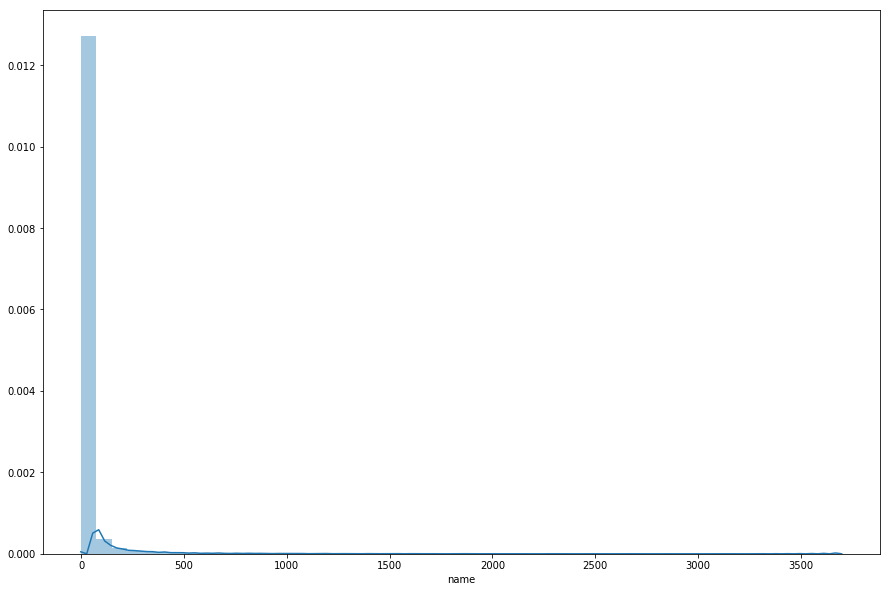

In [84]:
plt.figure(figsize=(15,10))
sns.distplot(df['name'].value_counts())

In [90]:
pd.DataFrame(df['name'].value_counts().describe().astype(int))

,name
count,110159
mean,26
std,112
min,1
25%,2
50%,4
75%,13
max,3696


In [91]:
sum(1 if v > 112 else 0 for v in df['name'].value_counts())

4660

In [107]:
df2 = pd.DataFrame(df['name'].value_counts()>300).reset_index()
idx = df2.index[df2['name']]
beers = df2.loc[idx]['index']

In [108]:
len(beers)

1875

In [109]:
df_final = df[df['name'].isin(beers)]

In [110]:
df_final['name'] = df_final['name'].str.replace('&#40;', '(').str.replace('&#41;', ')')
df_final['style'] = df_final['style'].str.replace('&#40;', '(').str.replace('&#41;', ')')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [111]:
len(df_final)

1304719

In [112]:
df_final.to_csv(path+'beers1875.csv', index=False)

#  
#### Preprocessing for drawing network

In [3]:
df = pd.read_csv(path+'beers1875.csv')
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ABV,appearance,aroma,beerID,brewerId,name,overall,palate,profileName,style,taste,text,time
0,7,3/5,7/10,51,12,Chimay Rouge (Red) / Premire,14/20,3/5,azlondon,Abbey Dubbel,8/10,Appearance,1214524800
1,7,3/5,7/10,51,12,Chimay Rouge (Red) / Premire,14/20,4/5,blipp,Abbey Dubbel,7/10,Bottle. Pours cloudy brown with a fizzy beige...,1214179200
2,7,4/5,8/10,51,12,Chimay Rouge (Red) / Premire,15/20,4/5,Goba,Abbey Dubbel,7/10,Finally one of the Chimay familly! Got this o...,1214092800
3,7,4/5,7/10,51,12,Chimay Rouge (Red) / Premire,11/20,2/5,uhre,Abbey Dubbel,8/10,"Pours brown colour with a tint of red, the he...",1214092800
4,7,3/5,5/10,51,12,Chimay Rouge (Red) / Premire,17/20,4/5,metsbcd,Abbey Dubbel,8/10,"Very good beer, had it at a Mortons. Appearan...",1213747200


In [4]:
len(df.name.unique())

1875

In [5]:
len(df)

1304719

In [6]:
df[df.columns] = df[df.columns].apply(lambda x: x.astype(str).str.strip())
df.head()

,ABV,appearance,aroma,beerID,brewerId,name,overall,palate,profileName,style,taste,text,time
0,7.0,3/5,7/10,51,12,Chimay Rouge (Red) / Premire,14/20,3/5,azlondon,Abbey Dubbel,8/10,Appearance,1214524800
1,7.0,3/5,7/10,51,12,Chimay Rouge (Red) / Premire,14/20,4/5,blipp,Abbey Dubbel,7/10,Bottle. Pours cloudy brown with a fizzy beige ...,1214179200
2,7.0,4/5,8/10,51,12,Chimay Rouge (Red) / Premire,15/20,4/5,Goba,Abbey Dubbel,7/10,Finally one of the Chimay familly! Got this on...,1214092800
3,7.0,4/5,7/10,51,12,Chimay Rouge (Red) / Premire,11/20,2/5,uhre,Abbey Dubbel,8/10,"Pours brown colour with a tint of red, the hea...",1214092800
4,7.0,3/5,5/10,51,12,Chimay Rouge (Red) / Premire,17/20,4/5,metsbcd,Abbey Dubbel,8/10,"Very good beer, had it at a Mortons. Appearanc...",1213747200


In [7]:
use_cols = ['name', 'ABV', 'brewerId', 'style', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'profileName']
df = df.loc[:, use_cols]
df.head()

,name,ABV,brewerId,style,appearance,aroma,palate,taste,overall,profileName
0,Chimay Rouge (Red) / Premire,7.0,12,Abbey Dubbel,3/5,7/10,3/5,8/10,14/20,azlondon
1,Chimay Rouge (Red) / Premire,7.0,12,Abbey Dubbel,3/5,7/10,4/5,7/10,14/20,blipp
2,Chimay Rouge (Red) / Premire,7.0,12,Abbey Dubbel,4/5,8/10,4/5,7/10,15/20,Goba
3,Chimay Rouge (Red) / Premire,7.0,12,Abbey Dubbel,4/5,7/10,2/5,8/10,11/20,uhre
4,Chimay Rouge (Red) / Premire,7.0,12,Abbey Dubbel,3/5,5/10,4/5,8/10,17/20,metsbcd


In [8]:
df = df[~df['ABV'].astype(str).str.contains('-')]

In [9]:
rating_cols = ['appearance', 'aroma', 'palate', 'taste', 'overall']
for col in rating_cols:
    df.loc[:,col] = df.loc[:,col].apply(lambda x: x.split('/')[0])
df.loc[:, rating_cols] = df.loc[:, rating_cols].astype(int)
df['ABV'] = df['ABV'].astype('float')

In [10]:
df.head()

,name,ABV,brewerId,style,appearance,aroma,palate,taste,overall,profileName
0,Chimay Rouge (Red) / Premire,7.0,12,Abbey Dubbel,3,7,3,8,14,azlondon
1,Chimay Rouge (Red) / Premire,7.0,12,Abbey Dubbel,3,7,4,7,14,blipp
2,Chimay Rouge (Red) / Premire,7.0,12,Abbey Dubbel,4,8,4,7,15,Goba
3,Chimay Rouge (Red) / Premire,7.0,12,Abbey Dubbel,4,7,2,8,11,uhre
4,Chimay Rouge (Red) / Premire,7.0,12,Abbey Dubbel,3,5,4,8,17,metsbcd


In [11]:
df.loc[:, rating_cols] = df.loc[:, rating_cols].astype(int)

In [12]:
df_copy = df.copy()

In [13]:
len(df_copy.name.unique())

1872

#### brewerId 중복값 처리 : 같은 맥주인데 다른 brewerId를 갖는 경우

In [14]:
df['brewerId'] = df['brewerId'].astype(int)

In [15]:
x = df.groupby(['name', 'ABV'])['brewerId'].agg('unique').reset_index()
x = x[x['brewerId'].str.len()>1]
x['brewerId'] = x['brewerId'].apply(lambda x: sorted(x))
bi1 = [a[0] for a in x['brewerId'].tolist()]
bi2 = [a[1] for a in x['brewerId'].tolist()]

x.head()

,name,ABV,brewerId
0,13th Century Grut Bier,4.6,"[2698, 11827]"
1,1809 Berliner Style Weisse,5.0,"[2698, 11827]"
2,21st Amendment Back in Black,6.8,"[1306, 1391]"
3,21st Amendment Bitter American,4.4,"[1306, 1391]"
4,21st Amendment Brew Free or Die IPA,7.0,"[1306, 1391]"


In [16]:
replace_dict = dict([(a, b) for a, b in zip(bi2, bi1)])
df['brewerId'] = df['brewerId'].replace(replace_dict)

In [17]:
x = df.groupby(['name', 'ABV'])['brewerId'].agg('unique').reset_index()
x = x[x['brewerId'].str.len()>1]
x['brewerId'] = x['brewerId'].apply(lambda x: sorted(x))
bi1 = [a[0] for a in x['brewerId'].tolist()]
bi2 = [a[1] for a in x['brewerId'].tolist()]

x.head()

,name,ABV,brewerId
370,Coney Island Albino Python,6.00,"[528, 3074]"
371,Coney Island Freaktoberfest,6.66,"[528, 3074]"
372,Coney Island Human Blockhead,10.00,"[528, 3074]"
373,Coney Island Lager,5.50,"[528, 3074]"
374,Coney Island Sword Swallower Steel Hop Lager,6.80,"[528, 3074]"


In [18]:
replace_dict = dict([(a, b) for a, b in zip(bi2, bi1)])
df['brewerId'] = df['brewerId'].replace(replace_dict)

In [19]:
x = df.groupby(['name', 'ABV'])['brewerId'].agg('unique').reset_index()
x = x[x['brewerId'].str.len()>1]
x['brewerId'] = x['brewerId'].apply(lambda x: sorted(x))
bi1 = [a[0] for a in x['brewerId'].tolist()]
bi2 = [a[1] for a in x['brewerId'].tolist()]

x.head()

,name,ABV,brewerId


#### 고유한 맥주 이름만 남기기 : 같은 맥주 이름인데 다른 속성값 가진 경우

In [20]:
x = df.groupby(['name'])['style'].agg('unique').reset_index()
x = x[x['style'].str.len()>1]
drop_beers = x['name'].tolist()
df = df[~df['name'].isin(drop_beers)]

#### 맥주별 rating 구하기
weighted rating (WR) = (v / (v+m)) * R + (m / (v+m)) * C 

where:  
R = average for the design (mean) = (Rating)  
v = number of votes for the design = (Rate Count)  
m = minimum votes required to be listed in the top beers list (varies according to average of ratecounts for top 50 beers)  
C = the mean vote across the whole report 

This formula normalizes scores, that is it pulls a particular score (R) to the mean (C) if the number of votes is not well above m. In other words, if a particular beer has only a few votes above the minimum required votes to be listed in top 50 (m), the average score is decreased a little if it is above the mean, or increased a little if it is below the mean in accordance with the normal distribution rule of statistics.   


The idea is that the more the votes, the more representative the average rating is.  

In [21]:
min_votes = df.name.value_counts()[0:50].min()

In [22]:
def scoring(arr):
    r = np.mean(arr)
    v = len(arr)
    m = min_votes
    c = 2.75
    
    rate = (v/(v+m))*r + (m/(v+m))*c 
    
    return rate

In [23]:
beer = df.groupby(['name', 'ABV', 'brewerId', 'style'])[rating_cols].agg(scoring)
#.reset_index()
beer.loc[:, rating_cols] = np.round(beer.loc[:, rating_cols], 2)
#beer.columns = ['name'] + rating_cols
beer_table = beer
beer.head()

,,,,appearance,aroma,palate,taste,overall
name,ABV,brewerId,style,,,,,
13th Century Grut Bier,4.6,2698,Traditional Ale,2.82,3.34,2.83,3.31,4.30
1809 Berliner Style Weisse,5.0,2698,Berliner Weisse,3.02,4.33,3.08,4.45,7.32
21st Amendment Back in Black,6.8,1306,Black IPA,3.12,4.02,2.96,4.03,6.34
21st Amendment Bitter American,4.4,1306,American Pale Ale,2.87,3.37,2.84,3.35,4.40
21st Amendment Brew Free or Die IPA,7.0,1306,India Pale Ale (IPA),3.09,4.42,3.06,4.41,7.34


#### 표준화
1. 점수, 알코올도수 표준화 : minmax_scale

In [24]:
beer = beer[rating_cols].apply(lambda x: minmax_scale(x))
beer.head()

,,,,appearance,aroma,palate,taste,overall
name,ABV,brewerId,style,,,,,
13th Century Grut Bier,4.6,2698,Traditional Ale,0.371951,0.272472,0.454545,0.225989,0.177986
1809 Berliner Style Weisse,5.0,2698,Berliner Weisse,0.493902,0.550562,0.616883,0.548023,0.531616
21st Amendment Back in Black,6.8,1306,Black IPA,0.554878,0.463483,0.538961,0.429379,0.416862
21st Amendment Bitter American,4.4,1306,American Pale Ale,0.402439,0.280899,0.461039,0.237288,0.189696
21st Amendment Brew Free or Die IPA,7.0,1306,India Pale Ale (IPA),0.536585,0.575843,0.603896,0.536723,0.533958


In [25]:
beer.describe().round(2)

,appearance,aroma,palate,taste,overall
count,1867.00,1867.00,1867.00,1867.00,1867.00
mean,0.45,0.36,0.50,0.33,0.31
std,0.10,0.15,0.10,0.15,0.16
min,0.00,0.00,0.00,0.00,0.00
25%,0.40,0.27,0.45,0.24,0.20
50%,0.43,0.33,0.49,0.29,0.26
75%,0.49,0.43,0.54,0.40,0.37
max,1.00,1.00,1.00,1.00,1.00


In [26]:
beer_table = beer

In [27]:
beer.reset_index(inplace=True)
beer

,name,ABV,brewerId,style,appearance,aroma,palate,taste,overall
0,13th Century Grut Bier,4.60,2698,Traditional Ale,0.371951,0.272472,0.454545,0.225989,0.177986
1,1809 Berliner Style Weisse,5.00,2698,Berliner Weisse,0.493902,0.550562,0.616883,0.548023,0.531616
2,21st Amendment Back in Black,6.80,1306,Black IPA,0.554878,0.463483,0.538961,0.429379,0.416862
3,21st Amendment Bitter American,4.40,1306,American Pale Ale,0.402439,0.280899,0.461039,0.237288,0.189696
4,21st Amendment Brew Free or Die IPA,7.00,1306,India Pale Ale (IPA),0.536585,0.575843,0.603896,0.536723,0.533958
5,21st Amendment Fireside Chat,7.90,1306,Spice/Herb/Vegetable,0.414634,0.255618,0.435065,0.203390,0.175644
6,21st Amendment Hell or High Watermelon Wheat,5.50,1306,Fruit Beer,0.371951,0.348315,0.441558,0.322034,0.319672
7,21st Amendment Hop Crisis&#033;,9.70,1306,Imperial/Double IPA,0.457317,0.382022,0.532468,0.344633,0.296253
8,21st Amendment Monks Blood,8.30,1306,Belgian Strong Ale,0.481707,0.424157,0.538961,0.395480,0.365340
9,3 Fonteinen Doesjel,6.00,2058,Lambic - Gueuze,0.402439,0.353933,0.500000,0.316384,0.265808


In [28]:
beer['ABV'] = minmax_scale(beer['ABV'].tolist())

In [29]:
def similarity_euclid(u, v):
    # for numeric features
    return 1/(1+euclidean(u,v))

def similarity_boolean(u, v):
    # for style, brewer
    similarity = 0
    if u == v:
        similarity = 1
    return similarity

In [33]:
mat_sim_appearance = pdist(beer['appearance'].as_matrix().reshape(len(beer), -1), similarity_euclid)
mat_sim_aroma = pdist(beer['aroma'].as_matrix().reshape(len(beer), -1), similarity_euclid)
mat_sim_palate = pdist(beer['palate'].as_matrix().reshape(len(beer), -1), similarity_euclid)
mat_sim_taste = pdist(beer['taste'].as_matrix().reshape(len(beer), -1), similarity_euclid)
mat_sim_overall = pdist(beer['overall'].as_matrix().reshape(len(beer), -1), similarity_euclid)
mat_sim_abv = pdist(beer['ABV'].as_matrix().reshape(len(beer), -1), similarity_euclid)
mat_sim_style = pdist(beer['style'].as_matrix().reshape(len(beer), -1), similarity_boolean)
mat_sim_brewer = pdist(beer['brewerId'].as_matrix().reshape(len(beer), -1), similarity_boolean)
mat_sim_review = pdist(tfidf, 'cosine')

In [ ]:
sim_appearance = pd.DataFrame(squareform(mat_sim_appearance), columns=beer.name, index=beer.name)
sim_aroma = pd.DataFrame(squareform(mat_sim_aroma), columns=beer.name, index=beer.name)
sim_palate = pd.DataFrame(squareform(mat_sim_palate), columns=beer.name, index=beer.name)
sim_taste = pd.DataFrame(squareform(mat_sim_taste), columns=beer.name, index=beer.name)
sim_overall = pd.DataFrame(squareform(mat_sim_overall), columns=beer.name, index=beer.name)
sim_abv = pd.DataFrame(squareform(mat_sim_abv), columns=beer.name, index=beer.name)
sim_style = pd.DataFrame(squareform(mat_sim_style), columns=beer.name, index=beer.name)
sim_brewer = pd.DataFrame(squareform(mat_sim_brewer), columns=beer.name, index=beer.name)
sim_review = pd.DataFrame(squareform(mat_sim_review), columns=beer.name, index=beer.name)

In [495]:
sim_list = [sim_appearance, sim_aroma, sim_palate, sim_taste, sim_overall,\
            sim_abv, sim_style, sim_brewer, sim_review]

In [340]:
beer.head()

,name,ABV,brewerId,style,appearance,aroma,palate,taste,overall
0,13th Century Grut Bier,0.157895,2698,Traditional Ale,0.371951,0.272472,0.454545,0.225989,0.177986
1,1809 Berliner Style Weisse,0.172932,2698,Berliner Weisse,0.493902,0.550562,0.616883,0.548023,0.531616
2,21st Amendment Back in Black,0.240602,1306,Black IPA,0.554878,0.463483,0.538961,0.429379,0.416862
3,21st Amendment Bitter American,0.150376,1306,American Pale Ale,0.402439,0.280899,0.461039,0.237288,0.189696
4,21st Amendment Brew Free or Die IPA,0.248120,1306,India Pale Ale (IPA),0.536585,0.575843,0.603896,0.536723,0.533958


In [34]:
temp = df.groupby('name')['profileName'].unique().reset_index()
temp.head()

,name,profileName
0,13th Century Grut Bier,"[Snojerk321, jkwalking05, ilovedarkbeer, AmEri..."
1,1809 Berliner Style Weisse,"[Aurelius, arminjewell, MaltOMeal, adnielsen, ..."
2,21st Amendment Back in Black,"[MadIndian, amg800, liveFREEorRYE, hivemind, C..."
3,21st Amendment Bitter American,"[cakanator, joshwilfong, ben4321, maniac, neep..."
4,21st Amendment Brew Free or Die IPA,"[Bricks, blazingspiral, badhack, PhatB420, sta..."


In [35]:
def co_reviewers(u, v):
    return len(set(u[0]) & set(v[0]))

In [36]:
num_co_reviewers = pdist(temp['profileName'].as_matrix().reshape(len(temp), -1), co_reviewers)
co_reviewer = pd.DataFrame(squareform(num_co_reviewers), columns=temp.name, index=temp.name)

In [ ]:
pd.DataFrame(squareform(minmax_scale(num_co_reviewers)), columns=temp.name, index=temp.name)

In [37]:
sim_appearance = pd.DataFrame(squareform(mat_sim_appearance), columns=beer.name, index=beer.name)
sim_aroma = pd.DataFrame(squareform(mat_sim_aroma), columns=beer.name, index=beer.name)
sim_palate = pd.DataFrame(squareform(mat_sim_palate), columns=beer.name, index=beer.name)
sim_taste = pd.DataFrame(squareform(mat_sim_taste), columns=beer.name, index=beer.name)
sim_overall = pd.DataFrame(squareform(mat_sim_overall), columns=beer.name, index=beer.name)
sim_abv = pd.DataFrame(squareform(mat_sim_abv), columns=beer.name, index=beer.name)
sim_style = pd.DataFrame(squareform(mat_sim_style), columns=beer.name, index=beer.name)
sim_brewer = pd.DataFrame(squareform(mat_sim_brewer), columns=beer.name, index=beer.name)

In [38]:
x1 = np.array([[a] for a in mat_sim_appearance])
x2 = np.array([[a] for a in mat_sim_aroma])
x3 = np.array([[a] for a in mat_sim_palate])
x4 = np.array([[a] for a in mat_sim_taste])
x5 = np.array([[a] for a in mat_sim_overall])
x6 = np.array([[a] for a in mat_sim_abv])
x7 = np.array([[a] for a in mat_sim_style])
x8 = np.array([[a] for a in mat_sim_brewer])
x9 = np.array([[a] for a in mat_sim_review])

In [39]:
y = minmax_scale(np.array([[a] for a in num_co_reviewers]))
y

array([[ 0.06323304],
       [ 0.03161652],
       [ 0.01529832],
       ..., 
       [ 0.13870474],
       [ 0.16369199],
       [ 0.32483427]])

In [40]:
A = np.hstack([x1, x2, x3, x4, x5, x6, x7, x8, x9, np.ones((len(x1), 1))])
A = np.asmatrix(A)
theta = (A.T*A).I*A.T*y

In [41]:
theta

matrix([[-0.16261514],
        [ 0.28420734],
        [-0.12611453],
        [ 0.11537377],
        [-0.42650077],
        [ 0.02077719],
        [ 0.02300397],
        [ 0.06452205],
        [-0.05700535],
        [ 0.35893622]])

In [473]:
A = np.hstack([sim_appearance, sim_aroma, sim_palate, sim_taste, sim_overall,\
               sim_abv, sim_style, sim_brewer, np.ones((len(sim_abv), 1))])
A = np.asmatrix(A)
y = co_reviewer


In [474]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(A, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [475]:
slr.coef_

array([[  2.85653679e-03,  -6.74068575e-04,   4.74880354e-04, ...,
          2.65092988e-04,  -3.33441972e-05,   0.00000000e+00],
       [  2.24020091e-04,   1.93841804e-02,   1.91135243e-03, ...,
          9.01563473e-04,  -2.42300395e-03,   0.00000000e+00],
       [  1.02208832e-03,   2.17180231e-03,   1.23373035e-02, ...,
          2.67773145e-03,   2.06846638e-04,   0.00000000e+00],
       ..., 
       [  7.48955818e-04,   3.17467166e-03,   8.72350721e-04, ...,
          3.54150087e-03,   5.95388799e-03,   0.00000000e+00],
       [  6.68626243e-04,   5.14122952e-03,   1.82436866e-03, ...,
          2.88235492e-02,  -7.89170404e-05,   0.00000000e+00],
       [  1.78011948e-03,   8.67320947e-03,   3.60019733e-03, ...,
         -1.28933000e-02,   4.09159200e-02,   0.00000000e+00]])

In [32]:
tfidf = pd.read_csv(path+'tfidf.csv')

In [ ]:
sim_list = [sim_appearance, sim_aroma, sim_palate, sim_taste, sim_overall,\
            sim_abv, sim_style, sim_brewer, sim_review]

In [497]:
distance1 = sim_appearance + sim_aroma + sim_palate + sim_taste + sim_overall\
            + sim_abv + sim_style + sim_brewer + sim_review
distance1.head()

name,13th Century Grut Bier,1809 Berliner Style Weisse,21st Amendment Back in Black,21st Amendment Bitter American,21st Amendment Brew Free or Die IPA,21st Amendment Fireside Chat,21st Amendment Hell or High Watermelon Wheat,21st Amendment Hop Crisis&#033;,21st Amendment Monks Blood,3 Fonteinen Doesjel,...,Youngs Oatmeal Stout (London Stout),Youngs Old Nick,Youngs Ram Rod (Pasteurised),Youngs Special London Ale,Youngs Winter Warmer (Bottle),Yuengling Dark Brewed Porter,Yuengling Light Lager,Yuengling Lord Chesterfield Ale,Yuengling Original Black and Tan,Yuengling Traditional Lager
name,,,,,,,,,,,,,,,,,,,,,
13th Century Grut Bier,0.000000,6.469683,6.133474,6.830127,5.834751,6.756718,6.580649,6.347414,6.250211,6.583457,...,6.153971,6.264511,6.914702,6.338494,6.868972,6.784915,6.527655,6.677084,6.634350,6.313975
1809 Berliner Style Weisse,6.469683,0.000000,5.871467,5.320618,6.100684,5.223303,5.413257,5.514177,5.706304,5.462098,...,5.906578,5.772617,5.304635,5.756369,5.395081,5.464556,4.992060,5.112203,5.567536,5.914484
21st Amendment Back in Black,6.133474,5.871467,0.000000,6.327673,6.712806,6.279653,6.537547,6.645480,6.858416,5.577152,...,5.953891,5.919256,5.263549,5.889056,5.362952,5.440845,4.926231,5.097795,5.576524,5.760372
21st Amendment Bitter American,6.830127,5.320618,6.327673,0.000000,5.971151,6.836161,6.708053,6.462732,6.369813,5.738279,...,5.245896,5.362622,5.930355,5.438056,5.954341,5.878869,5.528953,5.661166,5.738149,5.410774
21st Amendment Brew Free or Die IPA,5.834751,6.100684,6.712806,5.971151,0.000000,6.001884,6.161387,6.264827,6.475634,5.202671,...,5.623801,5.548507,4.938165,5.481364,5.026256,5.094426,4.635392,4.791261,5.210160,5.541449


In [510]:
distance2 = sim_appearance*theta[0,0] + sim_aroma*theta[1,0] + sim_palate*theta[2,0]\
            + sim_taste*theta[3,0] + sim_overall*theta[4,0] + sim_abv*theta[5,0]\
            + sim_style*theta[6,0] + sim_brewer*theta[7,0] + sim_review*theta[8,0]
distance2.head()

name,13th Century Grut Bier,1809 Berliner Style Weisse,21st Amendment Back in Black,21st Amendment Bitter American,21st Amendment Brew Free or Die IPA,21st Amendment Fireside Chat,21st Amendment Hell or High Watermelon Wheat,21st Amendment Hop Crisis&#033;,21st Amendment Monks Blood,3 Fonteinen Doesjel,...,Youngs Oatmeal Stout (London Stout),Youngs Old Nick,Youngs Ram Rod (Pasteurised),Youngs Special London Ale,Youngs Winter Warmer (Bottle),Yuengling Dark Brewed Porter,Yuengling Light Lager,Yuengling Lord Chesterfield Ale,Yuengling Original Black and Tan,Yuengling Traditional Lager
name,,,,,,,,,,,,,,,,,,,,,
13th Century Grut Bier,0.000000,-0.199843,-0.299324,-0.339705,-0.291265,-0.349552,-0.322936,-0.326783,-0.314429,-0.336054,...,-0.288942,-0.305991,-0.356628,-0.312164,-0.330820,-0.323291,-0.340174,-0.350213,-0.313684,-0.286887
1809 Berliner Style Weisse,-0.199843,0.000000,-0.288988,-0.258880,-0.310318,-0.264751,-0.265629,-0.277701,-0.288873,-0.261842,...,-0.291420,-0.296054,-0.262076,-0.289691,-0.268324,-0.275516,-0.247411,-0.252699,-0.284785,-0.322524
21st Amendment Back in Black,-0.299324,-0.288988,0.000000,-0.191555,-0.220893,-0.191569,-0.204365,-0.207354,-0.219689,-0.259178,...,-0.286045,-0.291108,-0.257898,-0.286478,-0.264333,-0.272269,-0.242505,-0.247804,-0.282920,-0.273269
21st Amendment Bitter American,-0.339705,-0.258880,-0.191555,0.000000,-0.180308,-0.235978,-0.204867,-0.215010,-0.202717,-0.291499,...,-0.239734,-0.257433,-0.302425,-0.263893,-0.284934,-0.273884,-0.279736,-0.289763,-0.265595,-0.238105
21st Amendment Brew Free or Die IPA,-0.291265,-0.310318,-0.220893,-0.180308,0.000000,-0.182923,-0.190623,-0.195456,-0.207335,-0.248204,...,-0.289228,-0.280070,-0.247075,-0.272891,-0.253175,-0.260230,-0.232409,-0.237010,-0.269222,-0.307184


In [512]:
distance = distance1*0.7 + distance2*0.3
distance

name,13th Century Grut Bier,1809 Berliner Style Weisse,21st Amendment Back in Black,21st Amendment Bitter American,21st Amendment Brew Free or Die IPA,21st Amendment Fireside Chat,21st Amendment Hell or High Watermelon Wheat,21st Amendment Hop Crisis&#033;,21st Amendment Monks Blood,3 Fonteinen Doesjel,...,Youngs Oatmeal Stout (London Stout),Youngs Old Nick,Youngs Ram Rod (Pasteurised),Youngs Special London Ale,Youngs Winter Warmer (Bottle),Yuengling Dark Brewed Porter,Yuengling Light Lager,Yuengling Lord Chesterfield Ale,Yuengling Original Black and Tan,Yuengling Traditional Lager
name,,,,,,,,,,,,,,,,,,,,,
13th Century Grut Bier,0.000000,4.468825,4.203635,4.679177,3.996946,4.624837,4.509574,4.345155,4.280819,4.507603,...,4.221097,4.293360,4.733303,4.343297,4.709034,4.652453,4.467306,4.568895,4.549940,4.333717
1809 Berliner Style Weisse,4.468825,0.000000,4.023330,3.646769,4.177384,3.576887,3.709591,3.776613,3.907751,3.744916,...,4.047179,3.952016,3.634622,3.942551,3.696060,3.742534,3.420219,3.502733,3.811839,4.043382
21st Amendment Back in Black,4.203635,4.023330,0.000000,4.371905,4.632696,4.338286,4.514973,4.589630,4.734984,3.826253,...,4.081910,4.056147,3.607115,4.036396,3.674766,3.726911,3.375610,3.494115,3.818690,3.950279
21st Amendment Bitter American,4.679177,3.646769,4.371905,0.000000,4.125713,4.714520,4.634177,4.459410,4.398054,3.929346,...,3.600207,3.676605,4.060521,3.727471,4.082558,4.033043,3.786347,3.875887,3.937026,3.716110
21st Amendment Brew Free or Die IPA,3.996946,4.177384,4.632696,4.125713,0.000000,4.146442,4.255784,4.326742,4.470743,3.567408,...,3.849892,3.799934,3.382593,3.755088,3.442426,3.488029,3.175052,3.282780,3.566346,3.786859
21st Amendment Fireside Chat,4.624837,3.576887,4.338286,4.714520,4.146442,0.000000,4.545760,4.478512,4.401538,3.840000,...,3.490502,3.658030,4.012465,3.671214,3.972842,3.908218,3.736334,3.883446,3.816967,3.590719
21st Amendment Hell or High Watermelon Wheat,4.509574,3.709591,4.514973,4.634177,4.255784,4.545760,0.000000,4.587120,4.523613,4.014788,...,3.701292,3.801042,3.880358,3.853910,3.916636,3.949047,3.623765,3.756494,4.032590,3.796626
21st Amendment Hop Crisis&#033;,4.345155,3.776613,4.589630,4.459410,4.326742,4.478512,4.587120,0.000000,4.681419,3.917333,...,3.722391,3.907556,3.676703,3.928060,3.756094,3.817626,3.421640,3.543722,3.903569,3.779107
21st Amendment Monks Blood,4.280819,3.907751,4.734984,4.398054,4.470743,4.401538,4.523613,4.681419,0.000000,3.833037,...,3.859688,4.052120,3.603495,4.048409,3.676839,3.733347,3.361310,3.480432,3.831614,3.876245


In [31]:
import networkx as nx

In [515]:
G = nx.from_pandas_adjacency(distance)

In [36]:
G = nx.from_pandas_adjacency(co_reviewer)

In [37]:
G.number_of_nodes()
G.number_of_edges()

1741911

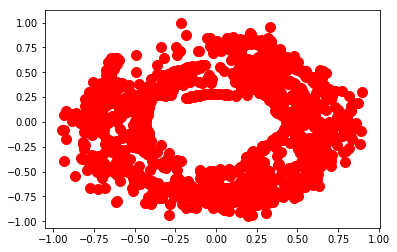

In [520]:
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos,node_size=100)

In [537]:
G

In [554]:
G = G.to_undirected()

In [39]:
x = G.edges()

In [547]:
x[start[0], end[0]]

{'weight': 4.4688251944637445}

In [40]:
start = [u for u,v in x]
end = [v for u,v in x]
weight = [G.get_edge_data(s,e)['weight'] for s,e in zip(start, end)]
edges = pd.DataFrame()
edges['start'] = start
edges['end'] = end
edges['weight'] = weight
edges.head()

,start,end,weight
0,13th Century Grut Bier,1809 Berliner Style Weisse,125.0
1,13th Century Grut Bier,21st Amendment Back in Black,63.0
2,13th Century Grut Bier,21st Amendment Bitter American,31.0
3,13th Century Grut Bier,21st Amendment Brew Free or Die IPA,82.0
4,13th Century Grut Bier,21st Amendment Fireside Chat,34.0


In [557]:
len(edges)

1741911

In [559]:
edges.columns = ['Source', 'Target', 'Weight']

In [566]:
edges10 = edges.copy()
edges10['Weight'] = edges10['Weight']*10

In [41]:
edges.to_csv(path+'edges_reviewer.csv', index=False)

In [ ]:
top = [edge for edge in G.edges_iter(data=True) 
       if edge[2]['weight'] > cutoff]

In [53]:
x = pd.DataFrame(edges['weight'].value_counts()).reset_index()
x[x['index'].astype(int)==0]

,index,weight


In [58]:
measure = pd.read_csv(path+'measures.csv')
measure.head()

,Id,Label,PageRank,Clustering Coefficient,Number of Triangles,Unnamed: 5,Degree,Weighted Degree,Eccen,Closeness,Harmonic Clustering coef,Betweenness,Eigenvector,Unnamed: 13,Unnamed: 14
0,Fort Collins Rocky Mountain IPA,Fort Collins Rocky Mountain IPA,0,0,0,4,53,222.670585,6,0.341115,0.448542,0.002394,1.000000,NaN,NaN
1,Full Sail Wreck the Halls,Full Sail Wreck the Halls,0,0,0,4,54,218.923163,6,0.356852,0.461977,0.007201,0.989451,NaN,NaN
2,Tyranena Bitter Woman IPA,Tyranena Bitter Woman IPA,0,0,0,4,52,213.144649,6,0.340233,0.444740,0.001640,0.973686,NaN,NaN
3,Left Hand 400 Pound Monkey,Left Hand 400 Pound Monkey,0,0,0,4,57,209.027858,5,0.375714,0.475475,0.032285,0.857716,NaN,NaN
4,Ninkasi Total Domination IPA,Ninkasi Total Domination IPA,0,0,0,4,52,208.719107,5,0.353020,0.450697,0.016978,0.888981,NaN,NaN


In [60]:
measure.columns = ['name', 'Label', 'PageRank', 'Clustering Coefficient',\
'Number of Triangles', 'Modularity', 'Degree', 'Weighted Degree',\
'Eccen', 'Closeness', 'Harmonic Clustering coef', 'Betweenness', 'Eigenvector', 'a', 'b']

In [61]:
measure = measure.merge(beer, on='name')

In [62]:
measure

,name,Label,PageRank,Clustering Coefficient,Number of Triangles,Modularity,Degree,Weighted Degree,Eccen,Closeness,...,a,b,ABV,brewerId,style,appearance,aroma,palate,taste,overall
0,Fort Collins Rocky Mountain IPA,Fort Collins Rocky Mountain IPA,0,0,0,4,53,222.670585,6,0.341115,...,NaN,NaN,6.20,3891,India Pale Ale (IPA),2.87,3.44,2.83,3.41,4.65
1,Full Sail Wreck the Halls,Full Sail Wreck the Halls,0,0,0,4,54,218.923163,6,0.356852,...,NaN,NaN,6.50,93,India Pale Ale (IPA),2.90,3.44,2.86,3.43,4.65
2,Tyranena Bitter Woman IPA,Tyranena Bitter Woman IPA,0,0,0,4,52,213.144649,6,0.340233,...,NaN,NaN,5.75,663,India Pale Ale (IPA),2.87,3.42,2.85,3.43,4.63
3,Left Hand 400 Pound Monkey,Left Hand 400 Pound Monkey,0,0,0,4,57,209.027858,5,0.375714,...,NaN,NaN,7.00,78,India Pale Ale (IPA),2.88,3.50,2.86,3.54,5.03
4,Ninkasi Total Domination IPA,Ninkasi Total Domination IPA,0,0,0,4,52,208.719107,5,0.353020,...,NaN,NaN,6.70,6779,India Pale Ale (IPA),2.88,3.35,2.85,3.36,4.42
5,Pike IPA,Pike IPA,0,0,0,4,53,208.668703,6,0.339355,...,NaN,NaN,6.30,193,India Pale Ale (IPA),2.86,3.40,2.86,3.42,4.59
6,Clown Shoes Tramp Stamp,Clown Shoes Tramp Stamp,0,0,0,4,50,208.605254,6,0.335459,...,NaN,NaN,7.00,801,India Pale Ale (IPA),2.86,3.38,2.85,3.38,4.46
7,Lagunitas Freak Out,Lagunitas Freak Out,0,0,0,4,54,204.825796,5,0.399090,...,NaN,NaN,7.30,1167,India Pale Ale (IPA),2.86,3.34,2.85,3.34,4.37
8,Moylans IPA,Moylans IPA,0,0,0,4,55,204.027175,5,0.341115,...,NaN,NaN,6.50,279,India Pale Ale (IPA),2.90,3.51,2.86,3.48,4.79
9,Two Brothers Heavy Handed India Pale Ale,Two Brothers Heavy Handed India Pale Ale,0,0,0,4,55,203.994603,5,0.341558,...,NaN,NaN,6.70,507,India Pale Ale (IPA),2.90,3.49,2.88,3.50,4.83


In [67]:
close = measure.sort_values(by=['Closeness'], ascending=False).iloc[:10]
weighted_degree = measure.sort_values(by=['Weighted Degree'], ascending=False).iloc[:10]
degree = measure.sort_values(by=['Degree'], ascending=False).iloc[:10]
between = measure.sort_values(by=['Betweenness'], ascending=False).iloc[:10]
CC = measure.sort_values(by=['Clustering Coefficient'], ascending=False).iloc[:10]

In [85]:
beer['style'].value_counts()

India Pale Ale (IPA)               135
Belgian Strong Ale                 112
Imperial Stout                      99
Imperial/Double IPA                 94
Pale Lager                          83
Barley Wine                         70
American Pale Ale                   64
American Strong Ale                 60
Porter                              57
Fruit Beer                          54
Spice/Herb/Vegetable                46
Brown Ale                           41
Abbey Tripel                        40
Premium Bitter/ESB                  39
Stout                               38
Belgian Ale                         38
Amber Ale                           38
Saison                              36
Wheat Ale                           34
Belgian White (Witbier)             31
Sour Ale/Wild Ale                   30
English Strong Ale                  29
German Hefeweizen                   28
Oktoberfest/Mrzen                   27
Doppelbock                          26
Sweet Stout              

In [86]:
measure.sort_values(by=['Closeness'], ascending=False).iloc[:100][['name','style', 'ABV', 'overall', 'Closeness']]

,name,style,ABV,overall,Closeness
16,Olympia,Pale Lager,4.80,3.57,0.833333
24,Hamms,Pale Lager,4.70,3.39,0.819672
29,Heilemans Old Style,Pale Lager,5.00,4.09,0.806452
28,Blatz,Pale Lager,4.89,3.44,0.806452
35,Strohs,Pale Lager,4.60,3.89,0.793651
41,Schmidt Beer,Pale Lager,4.40,3.30,0.769231
49,LandShark Lager,Pale Lager,4.70,3.78,0.769231
43,Schaefer,Pale Lager,4.40,3.49,0.757576
60,Quilmes Cristal,Pale Lager,4.90,3.82,0.735294
57,Presidente,Pale Lager,5.00,3.70,0.735294


In [83]:
measure.sort_values(by=['Weighted Degree'], ascending=False).iloc[:100][['name','style', 'ABV', 'overall', 'Weighted Degree']]

,name,style,ABV,overall,Weighted Degree
0,Fort Collins Rocky Mountain IPA,India Pale Ale (IPA),6.20,4.65,222.670585
1,Full Sail Wreck the Halls,India Pale Ale (IPA),6.50,4.65,218.923163
2,Tyranena Bitter Woman IPA,India Pale Ale (IPA),5.75,4.63,213.144649
3,Left Hand 400 Pound Monkey,India Pale Ale (IPA),7.00,5.03,209.027858
4,Ninkasi Total Domination IPA,India Pale Ale (IPA),6.70,4.42,208.719107
5,Pike IPA,India Pale Ale (IPA),6.30,4.59,208.668703
6,Clown Shoes Tramp Stamp,India Pale Ale (IPA),7.00,4.46,208.605254
7,Lagunitas Freak Out,India Pale Ale (IPA),7.30,4.37,204.825796
8,Moylans IPA,India Pale Ale (IPA),6.50,4.79,204.027175
9,Two Brothers Heavy Handed India Pale Ale,India Pale Ale (IPA),6.70,4.83,203.994603


In [75]:
measure.sort_values(by=['Degree'], ascending=False).iloc[:10][['name','style', 'ABV', 'overall', 'Degree']]

,name,style,ABV,overall,Degree
15,13th Century Grut Bier,Traditional Ale,4.6,4.30,115
19,Nectar Ales Nectar IPA,India Pale Ale (IPA),6.8,4.72,59
3,Left Hand 400 Pound Monkey,India Pale Ale (IPA),7.0,5.03,57
30,Sierra Nevada Estate Homegrown Ale,India Pale Ale (IPA),6.7,4.48,57
22,Abita Jockamo IPA,India Pale Ale (IPA),6.5,4.96,57
9,Two Brothers Heavy Handed India Pale Ale,India Pale Ale (IPA),6.7,4.83,55
13,Boulevard Single Wide IPA,India Pale Ale (IPA),5.7,4.82,55
8,Moylans IPA,India Pale Ale (IPA),6.5,4.79,55
1,Full Sail Wreck the Halls,India Pale Ale (IPA),6.5,4.65,54
17,Magic Hat Blind Faith,India Pale Ale (IPA),6.2,4.99,54


In [78]:
measure.sort_values(by=['Betweenness'], ascending=False).iloc[:10][['name','style', 'ABV', 'overall', 'Betweenness']]

,name,style,ABV,overall,Betweenness
87,Lagunitas Kill Ugly Radio,India Pale Ale (IPA),7.8,5.39,0.085834
15,13th Century Grut Bier,Traditional Ale,4.6,4.30,0.078449
7,Lagunitas Freak Out,India Pale Ale (IPA),7.3,4.37,0.068538
137,Lagunitas A Little Sumpin Wild Ale,Belgian Strong Ale,9.4,5.55,0.061996
229,Stone 7th Anniversary Ale,American Strong Ale,7.7,4.44,0.051979
100,Ballast Point/Kelsey McNair/Stone San Diego Co...,American Pale Ale,4.2,4.36,0.037366
140,Three Floyds Arctic Panzer Wolf,Imperial/Double IPA,9.0,4.83,0.032764
3,Left Hand 400 Pound Monkey,India Pale Ale (IPA),7.0,5.03,0.032285
198,Stone 03.03.03 Vertical Epic Ale,Belgian Strong Ale,9.0,4.55,0.028054
180,Stone Old Guardian Belgo-Barley Wine,Barley Wine,12.0,4.56,0.026624


In [111]:
measure.groupby('Modularity')['Degree', 'Closeness','Betweenness', 'overall', 'ABV'].agg('mean')

,Degree,Closeness,Betweenness,overall,ABV
Modularity,,,,,
0,17.485714,0.145776,0.004108,4.815714,8.293143
1,28.931034,0.578872,0.000227,3.770000,4.727414
2,26.621622,0.281633,0.004889,4.627568,5.408919
3,15.114286,0.041498,0.000788,4.919143,9.694286
4,40.673267,0.290470,0.005912,5.019802,6.524752
5,15.571429,0.070279,0.001100,4.705714,7.338095
6,24.947368,0.206731,0.004142,5.081579,9.047368
7,23.515152,0.166803,0.003507,5.261212,9.110758
8,13.619048,0.062642,0.000556,4.561905,5.477619


In [115]:
measure.groupby('Clustering Coefficient')['Degree', 'Closeness','Betweenness', 'overall', 'ABV'].agg('mean')

,Degree,Closeness,Betweenness,overall,ABV
Clustering Coefficient,,,,,
0,24.529865,0.219586,0.003038,4.766435,7.302428


In [109]:
pd.DataFrame(measure.groupby('Modularity')['style'].agg('unique'))

,style
Modularity,
0,"[American Strong Ale, Spice/Herb/Vegetable]"
1,"[Pale Lager, Malt Liquor]"
2,[American Pale Ale]
3,"[Imperial Stout, Amber Ale]"
4,"[India Pale Ale (IPA), Traditional Ale]"
5,"[Saison, Belgian White (Witbier), Abbey Tripel..."
6,[Imperial/Double IPA]
7,"[Belgian Strong Ale, Abbey Tripel]"
8,"[Brown Ale, Porter]"


In [102]:
measure[measure['Modularitymeasure[measure['Modularity']==5]['style'].unique()

array(['Saison', 'Belgian White (Witbier)', 'Abbey Tripel',
       'English Strong Ale'], dtype=object)

In [107]:
measure['Modularity'].value_counts()

4     101
7      66
9      60
1      58
6      57
2      37
3      35
0      35
10     28
8      21
5      21
Name: Modularity, dtype: int64

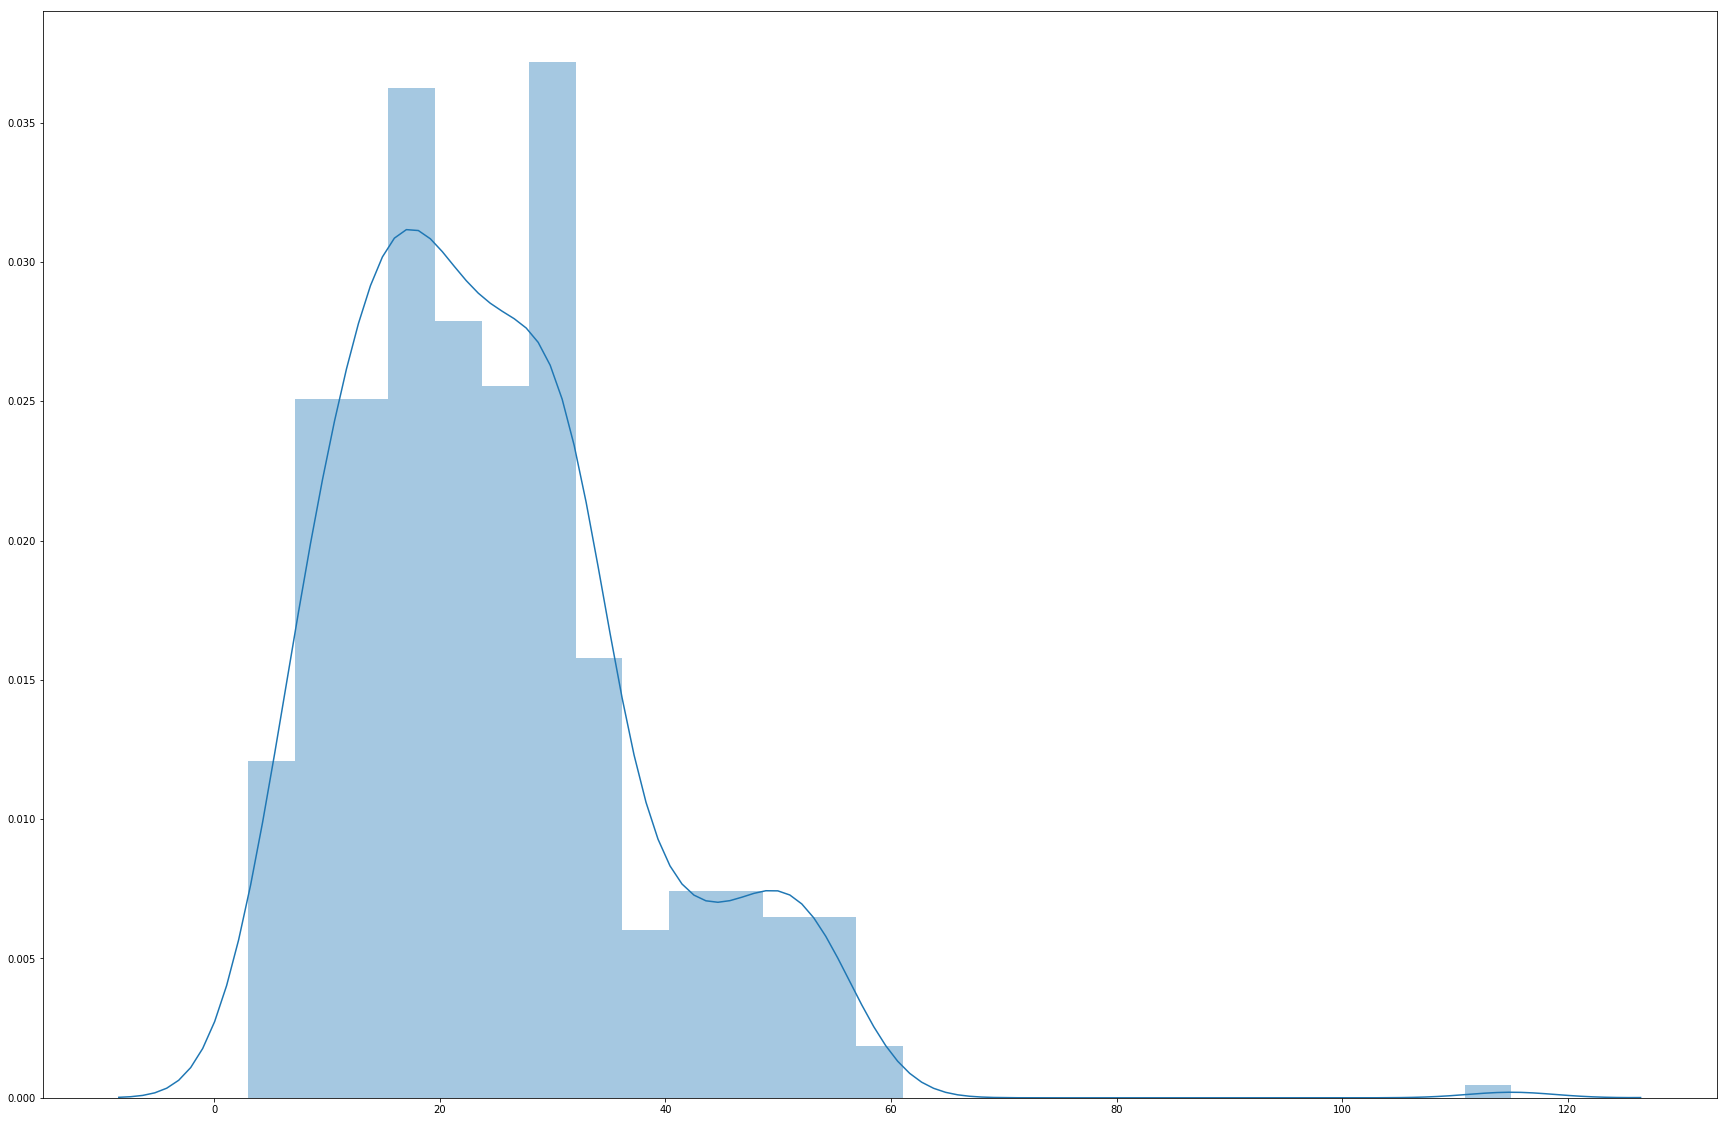

In [118]:
plt.figure(figsize=(30,20))
sns.distplot(measure.Degree.tolist())

In [134]:
x = pd.DataFrame(measure.Degree.value_counts()).reset_index()
x.columns = ['Degree', '# of nodes']

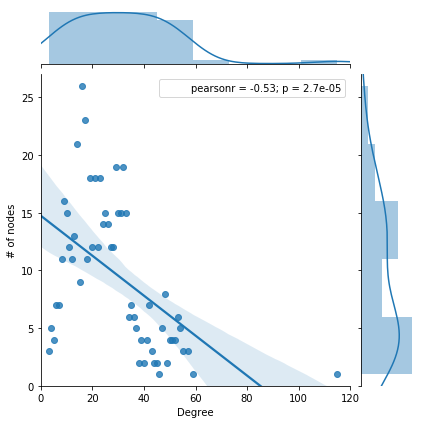

In [143]:
plt.figure(figsize=(40,30))
sns.jointplot(x['Degree'],x['# of nodes'], kind='reg',\
             xlim=[0,120], ylim=[0,27])

In [156]:
measure.Modularity.value_counts()

4     101
7      66
9      60
1      58
6      57
2      37
3      35
0      35
10     28
8      21
5      21
Name: Modularity, dtype: int64